<a href="https://colab.research.google.com/github/nicolezk/pet-adoption-prediction/blob/main/notebooks/data_wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook configuration

In [12]:
# Mount Google Drive to obtain the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%%capture
# Install libraries
!pip install pandas-profiling==2.7.1 # get it to work with colab
!pip install --force-reinstall pandas

In [14]:
# Import libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

In [15]:
# Read csv files
path_to_dir = '/content/drive/MyDrive/ML - Project/data/'

df = pd.read_csv(path_to_dir + 'train.csv.zip')
breed_labels = pd.read_csv(path_to_dir + 'BreedLabels.csv')
color_labels = pd.read_csv(path_to_dir + 'ColorLabels.csv')
state_labels = pd.read_csv(path_to_dir + 'StateLabels.csv')

## Dataset Overview

Let's take an overview on the files we have.

In [16]:
df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

According to the [Competition profile on Kaggle](https://www.kaggle.com/c/petfinder-adoption-prediction/data), here is the description of the columns:

1. **PetID**: Unique hash ID of pet profile
2. **AdoptionSpeed**: Categorical speed of adoption. Lower is faster. This is the value to predict.
> - 0 - Pet was adopted on the same day as it was listed.
> - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.- 
> - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
> - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
> - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).
3. **Type**: Type of animal (1 = Dog, 2 = Cat)
4. **Name**: Name of pet (Empty if not named)
5. **Age**: Age of pet when listed, in months
6. **Breed1**: Primary breed of pet (Refer to BreedLabels dictionary)
7. **Breed2**: Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
8. **Gender**: Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
9. **Color1**: Color 1 of pet (Refer to ColorLabels dictionary)
10. **Color2**: Color 2 of pet (Refer to ColorLabels dictionary)
11. **Color3**: Color 3 of pet (Refer to ColorLabels dictionary)
12. **MaturitySize**: Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
13. **FurLength**: Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
14. **Vaccinated**: Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
15. **Dewormed**: Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
16. **Sterilized**: Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
17. **Health**: Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
18. **Quantity**: Number of pets represented in profile
19. **Fee**: Adoption fee (0 = Free)
20. **State**: State location in Malaysia (Refer to StateLabels dictionary)
21. **RescuerID**: Unique hash ID of rescuer
22. **VideoAmt**: Total uploaded videos for this pet
23. **PhotoAmt**: Total uploaded photos for this pet
24. **Description**: Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.



In [17]:
breed_labels.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [18]:
color_labels.head()

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream


In [19]:
state_labels.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


Now we want to perform some tasks on the data to make sure it is consistent, concise and noise-free.

Tasks:
- Merging datasets
- De-duplication
- Handle missing data
- Checking consistency
- Normalizing/Scaling/Standardization
- Removing noisy data



## Merging Datasets
Overview of this task:

We have 4 different datasets that we want to merge into 1 single dataframe. The smaller datasets (breed_labels, color_labels and breed_labels) will be incorporated into the biggest dataset (df).


In [20]:
# First, Let's check if all the pets have a reference for breed, state and color.
# We do this by checking if there's any missing value (NaN) in those columns.
df.isnull().sum(axis = 0)

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

In [21]:
# Let's see how many distinct breed types we have before merging them.
breed_labels.Type.unique()
# If we had only 1 then we could just ignore it, but we have two values (1,2).

array([1, 2])

In [22]:
# Merging
df = pd.merge(df, breed_labels, how='left', left_on='Breed1', right_on='BreedID', suffixes=('', 'Breed1'))
df = pd.merge(df, breed_labels, how='left', left_on='Breed2', right_on='BreedID', suffixes=('', 'Breed2'))
df = pd.merge(df, color_labels, how='left', left_on='Color1', right_on='ColorID', suffixes=('', 'Color1'))
df = pd.merge(df, color_labels, how='left', left_on='Color2', right_on='ColorID', suffixes=('', 'Color2'))
df = pd.merge(df, color_labels, how='left', left_on='Color3', right_on='ColorID', suffixes=('', 'Color3'))
df = pd.merge(df, state_labels, how='left', left_on='State', right_on='StateID')

# Removing redundant ID columns for breeds, colors and states
df.drop(['BreedID', 'BreedIDBreed2', 'ColorID', 'ColorIDColor2', 'ColorIDColor3', 'StateID'], axis = 1, inplace=True)

# Rearranging columns inside the dataframe
cols = ['Type', 'Name', 'Age', 'Breed1', 'TypeBreed1', 'BreedName', 'Breed2', 'TypeBreed2', 'BreedNameBreed2',
        'Gender', 'Color1', 'ColorName', 'Color2', 'ColorNameColor2', 'Color3', 'ColorNameColor3', 'MaturitySize',
        'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'StateName',
        'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed']
df = df[cols]

# Renaming columns to be more concise 
df.rename(columns={"TypeBreed1": "Breed1Type", "BreedName": "Breed1Name",  
                   "TypeBreed2": "Breed2Type", "BreedNameBreed2": "Breed2Name",
                   "ColorName": "Color1Name", "ColorNameColor2": "Color2Name",
                   "ColorNameColor3": "Color3Name"}, inplace=True)

df.head(1)

,Type,Name,Age,Breed1,Breed1Type,Breed1Name,Breed2,Breed2Type,Breed2Name,Gender,...,Quantity,Fee,State,StateName,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,2.0,Tabby,0,NaN,NaN,1,...,1,100,41326,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2


In [23]:
# Let's check how many null values we have after the merge
df.isnull().sum(axis = 0)

Type                 0
Name              1257
Age                  0
Breed1               0
Breed1Type           5
Breed1Name           5
Breed2               0
Breed2Type       10762
Breed2Name       10762
Gender               0
Color1               0
Color1Name           0
Color2               0
Color2Name        4471
Color3               0
Color3Name       10604
MaturitySize         0
FurLength            0
Vaccinated           0
Dewormed             0
Sterilized           0
Health               0
Quantity             0
Fee                  0
State                0
StateName            0
RescuerID            0
VideoAmt             0
Description         12
PetID                0
PhotoAmt             0
AdoptionSpeed        0
dtype: int64

## Deduplication

Overview of this task:

We just want to check if there is any duplicated records in our data and remove them if any.

In [24]:
# Counting rows in dataframe
len(df)

14993

In [25]:
# dropping duplicate values
df.drop_duplicates(keep=False,inplace=True)

In [26]:
# Count again to see the number of rows.
len(df)

# Conclusion: there were no duplicated rows in our data

14993

## Handle missing data

Overview of this task:

We want to see which columns have missing values and then decide what to do with them (remove, replace, leave it there, etc).

In [27]:
# First, let's check how many null values (NaN) we have per column
df.isnull().sum(axis = 0)

Type                 0
Name              1257
Age                  0
Breed1               0
Breed1Type           5
Breed1Name           5
Breed2               0
Breed2Type       10762
Breed2Name       10762
Gender               0
Color1               0
Color1Name           0
Color2               0
Color2Name        4471
Color3               0
Color3Name       10604
MaturitySize         0
FurLength            0
Vaccinated           0
Dewormed             0
Sterilized           0
Health               0
Quantity             0
Fee                  0
State                0
StateName            0
RescuerID            0
VideoAmt             0
Description         12
PetID                0
PhotoAmt             0
AdoptionSpeed        0
dtype: int64

The columns that contain missing values are:

*   Name (1257 null values)
*   Breed1Type (5)
*   Breed1Name (5)
*   Breed2Type (10762)
*   Breed2Name (10762)
*   Color2Name (4471)
*   Color3Name (10604)
*   Description (12)

We don't need take any action to deal with those missing values because they represent exactly what they're supposed to represent: the data doesn't exist in that case. For instance, if the name is null, it means that the animal doesn't have a name.

We are just going to check deeper inside the columns Breed1Type and Breed1Name beacause every pet should have at least a primary breed.

In [28]:
# Check rows where Breed1Type is null
df[df.Breed1Type.isnull()]

,Type,Name,Age,Breed1,Breed1Type,Breed1Name,Breed2,Breed2Type,Breed2Name,Gender,...,Quantity,Fee,State,StateName,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
391,1,Lil Milo,2,0,NaN,NaN,26,1.0,Belgian Shepherd Malinois,2,...,1,0,41326,Selangor,1a2113010d6048d5410b265347b35c91,0,Milo went missing after a week with her new ad...,375905770,3.0,3
1045,1,Bella 4 Months Puppy!,4,0,NaN,NaN,307,1.0,Mixed Breed,2,...,1,100,41326,Selangor,3673e167fc9932b13149bed1f2a0180a,0,"She's only 4 months old, very friendly and lov...",da8d4a273,5.0,4
3219,2,NaN,3,0,NaN,NaN,266,2.0,Domestic Short Hair,3,...,3,0,41401,Kuala Lumpur,f7cff59d10c867bdee12c3f35f34d086,0,Mama cat came to house and gave birth to these...,27e74e45c,11.0,2
7285,1,"""Boy Boy""",72,0,NaN,NaN,307,1.0,Mixed Breed,1,...,1,0,41326,Selangor,94b991f8dc1e0bb903ca8d4d492c8d43,0,He is a stray dog found wandering around Unive...,7b5bee232,5.0,4
7706,1,Looking Newborn Puppy For Adoption,2,0,NaN,NaN,205,1.0,Shih Tzu,2,...,1,1,41336,Johor,5232bdd1444960a257ccec9a41404320,0,I want to adopt a newborn puppy Prefer small b...,0327b8e94,0.0,3


As we can see above, the Breed code is always 0, which is a code that does not exist on the breed_labels reference dataset. However, for all those cases the animal has information on secondary breed. We are going to replace the primary breed by the secondary breed in the cases where Breed1Name is Null and also replace the Breed1Type with Type for when Breed1Type is null.

In [32]:
# Replacing when value is null
df.Breed1Type.fillna(df.Type, inplace=True)
df.Breed1Name.fillna(df.Breed2Name, inplace=True)

# Converting Breed1Type to Integer. We couldn't do it before because it had
# null values, which in this pandas version are considered as float.
df['Breed1Type'] = df['Breed1Type'].astype(int)

In [33]:
# We can see below that Breed1Name was replaced by Breed2Name
df[df.Name == 'Lil Milo']

,Type,Name,Age,Breed1,Breed1Type,Breed1Name,Breed2,Breed2Type,Breed2Name,Gender,...,Quantity,Fee,State,StateName,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
391,1,Lil Milo,2,0,1,Belgian Shepherd Malinois,26,1.0,Belgian Shepherd Malinois,2,...,1,0,41326,Selangor,1a2113010d6048d5410b265347b35c91,0,Milo went missing after a week with her new ad...,375905770,3.0,3


## Consistency check

In [34]:
df.PetID.is_unique

True

In [35]:
df.PetID.isna().sum()

0

In [36]:
df.AdoptionSpeed.value_counts(dropna=False)

4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

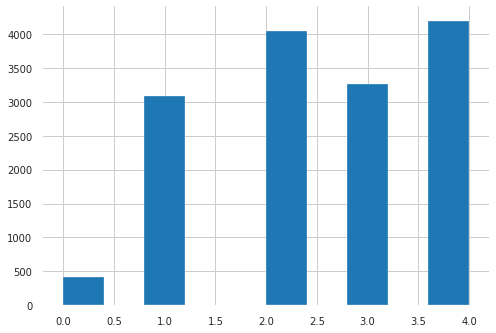

In [37]:
df.AdoptionSpeed.hist()

In [38]:
df.Type.value_counts(dropna=False)

1    8132
2    6861
Name: Type, dtype: int64

In [39]:
df.Name.is_unique

False

In [40]:
df.Name.value_counts(dropna=False)[:50]

NaN            1257
Baby             66
Lucky            64
No Name          54
Brownie          54
Mimi             52
Blackie          49
Puppy            45
Kittens          39
Max              39
Kitty            39
Oreo             36
Coco             35
Tiger            34
Angel            33
Milo             32
Bobby            30
Snowy            30
Lucy             29
Kiki             29
Lily             28
Tom              27
Ginger           26
Puppies          26
Prince           25
Happy            25
Daisy            24
Lola             23
Kitten           23
Bella            23
Rocky            23
Simba            23
Princess         22
Molly            22
Momo             22
No Name Yet      22
Luna             22
Buddy            21
Panda            21
Fluffy           21
Tommy            21
Bobo             20
Snow             20
Peanut           20
Cookie           20
Toby             19
Mickey           18
Shadow           18
Blacky           18
Lulu             17


In [41]:
# Guessing some generic "unnamed" names
df.Name.value_counts()[['Puppy', 'Puppies', 'Kitten', 'Kittens', 'Dog', 'Dogs', 'Cat', 'No Name', 'No Name Yet', 'Unnamed']]

Puppy          45
Puppies        26
Kitten         23
Kittens        39
Dog             3
Dogs            1
Cat             4
No Name        54
No Name Yet    22
Unnamed         5
Name: Name, dtype: int64

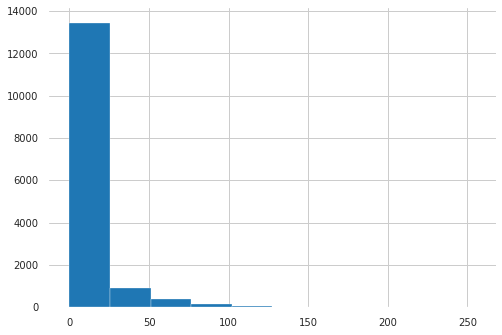

In [42]:
df.Age.hist()

In [43]:
df.Age.describe()

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64

In [44]:
(df.Age / 12).describe()

count    14993.000000
mean         0.871006
std          1.512983
min          0.000000
25%          0.166667
50%          0.250000
75%          1.000000
max         21.250000
Name: Age, dtype: float64

In [45]:
df[['Breed1', 'Breed1Type', 'Breed1Name', 'Breed2', 'Breed2Type', 'Breed2Name']]

,Breed1,Breed1Type,Breed1Name,Breed2,Breed2Type,Breed2Name
0,299,2,Tabby,0,NaN,NaN
1,265,2,Domestic Medium Hair,0,NaN,NaN
2,307,1,Mixed Breed,0,NaN,NaN
3,307,1,Mixed Breed,0,NaN,NaN
4,307,1,Mixed Breed,0,NaN,NaN
...,...,...,...,...,...,...
14988,266,2,Domestic Short Hair,0,NaN,NaN
14989,265,2,Domestic Medium Hair,264,2.0,Domestic Long Hair
14990,265,2,Domestic Medium Hair,266,2.0,Domestic Short Hair
14991,266,2,Domestic Short Hair,0,NaN,NaN


In [46]:
# Top dog breeds
df[df['Breed1Type'] == 1]['Breed1Name'].value_counts(dropna=False) / df[df['Breed1Type'] == 1].shape[0]

Mixed Breed                     0.728021
Labrador Retriever              0.025172
Shih Tzu                        0.023453
Poodle                          0.020506
Terrier                         0.019892
                                  ...   
Chocolate Labrador Retriever    0.000123
Sheep Dog                       0.000123
Australian Shepherd             0.000123
Old English Sheepdog            0.000123
Dutch Shepherd                  0.000123
Name: Breed1Name, Length: 116, dtype: float64

In [47]:
# Top cat breeds
df[df['Breed1Type'] == 2]['Breed1Name'].value_counts(dropna=False) / df[df['Breed1Type'] == 2].shape[0]

Domestic Short Hair                      0.530734
Domestic Medium Hair                     0.183676
Tabby                                    0.049934
Domestic Long Hair                       0.043218
Siamese                                  0.038546
Persian                                  0.032267
Calico                                   0.015331
American Shorthair                       0.013725
Oriental Short Hair                      0.010658
Bengal                                   0.010366
Tuxedo                                   0.008176
Tortoiseshell                            0.006132
Maine Coon                               0.004964
British Shorthair                        0.004964
Abyssinian                               0.004088
Russian Blue                             0.003796
Burmese                                  0.003358
Tiger                                    0.003066
Bobtail                                  0.002774
Oriental Long Hair                       0.002482


In [48]:
len(df[df['Breed1Type'] == 2]['Breed1Name'].unique())

59

In [49]:
df['Gender'].value_counts()

2    7277
1    5536
3    2180
Name: Gender, dtype: int64

In [50]:
df['Gender'].value_counts() / ((df['Gender']==1).sum() + (df['Gender']==2).sum())

2    0.567939
1    0.432061
3    0.170140
Name: Gender, dtype: float64

In [51]:
df['Color1Name'].value_counts(dropna=False) / df.shape[0]

Black     0.495365
Brown     0.250117
Golden    0.063163
Cream     0.058961
Gray      0.045621
White     0.044487
Yellow    0.042286
Name: Color1Name, dtype: float64

In [52]:
df['MaturitySize'].value_counts(dropna=False) / df.shape[0]

2    0.687321
1    0.226439
3    0.084039
4    0.002201
Name: MaturitySize, dtype: float64

In [53]:
df['FurLength'].value_counts(dropna=False) / df.shape[0]

1    0.587474
2    0.357567
3    0.054959
Name: FurLength, dtype: float64

In [54]:
df['Vaccinated'].value_counts(dropna=False) / df.shape[0]

2    0.482025
1    0.393384
3    0.124591
Name: Vaccinated, dtype: float64

In [55]:
df['Dewormed'].value_counts(dropna=False) / df.shape[0]

1    0.560061
2    0.321150
3    0.118789
Name: Dewormed, dtype: float64

In [56]:
df['Sterilized'].value_counts(dropna=False) / df.shape[0]

2    0.672114
1    0.206830
3    0.121056
Name: Sterilized, dtype: float64

In [57]:
df['Health'].value_counts(dropna=False) / df.shape[0]

1    0.965651
2    0.032082
3    0.002268
Name: Health, dtype: float64

In [58]:
df['Quantity'].value_counts()

1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
20       12
11       10
12        6
15        4
17        3
16        3
14        2
13        2
18        1
Name: Quantity, dtype: int64

In [59]:
df['Quantity'].value_counts() / df.shape[0]

1     0.771360
2     0.094844
3     0.048423
4     0.035417
5     0.022210
6     0.012339
7     0.005603
8     0.003468
9     0.002201
10    0.001267
20    0.000800
11    0.000667
12    0.000400
15    0.000267
17    0.000200
16    0.000200
14    0.000133
13    0.000133
18    0.000067
Name: Quantity, dtype: float64

In [60]:
df['Fee'].describe()

count    14993.000000
mean        21.259988
std         78.414548
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3000.000000
Name: Fee, dtype: float64

In [61]:
df['Fee'].value_counts() / df.shape[0]

0      0.844594
50     0.031215
100    0.027213
200    0.014607
150    0.010805
         ...   
170    0.000067
135    0.000067
14     0.000067
89     0.000067
190    0.000067
Name: Fee, Length: 74, dtype: float64

In [62]:
df['RescuerID'].is_unique

False

In [63]:
df['RescuerID'].value_counts()

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
                                   ... 
89bc6d71d57ad5d7e952ed76559345c5      1
8cfafc812c500eee7c112911ef668ce9      1
8512e22c06a01cdc76481ff0a6e88b67      1
48de9ff092328d54b2b371bc72b07b03      1
79309f4027f2fedb4349a298c69fe56f      1
Name: RescuerID, Length: 5595, dtype: int64

In [64]:
df['VideoAmt'].value_counts()

0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: VideoAmt, dtype: int64

In [65]:
df['VideoAmt'].value_counts() / df.shape[0]

0    0.961715
1    0.027813
2    0.006136
3    0.002401
4    0.001000
5    0.000467
6    0.000267
8    0.000133
7    0.000067
Name: VideoAmt, dtype: float64

In [66]:
df['PhotoAmt'].value_counts()

1.0     3075
2.0     2518
3.0     2511
5.0     2147
4.0     1881
6.0      621
7.0      432
0.0      341
8.0      314
9.0      231
10.0     190
11.0     184
12.0      97
13.0      86
14.0      78
15.0      50
16.0      39
17.0      27
20.0      25
19.0      20
30.0      19
18.0      18
21.0      16
24.0      15
23.0      12
26.0      10
22.0       9
25.0       8
28.0       7
27.0       6
29.0       6
Name: PhotoAmt, dtype: int64

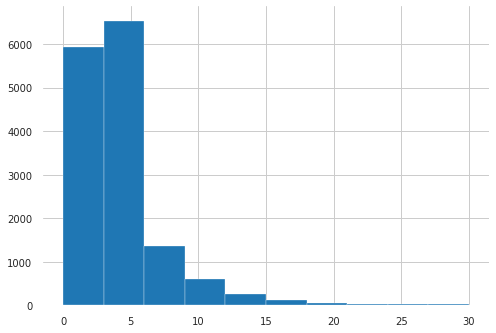

In [67]:
df['PhotoAmt'].hist()

In [68]:
df['Description'].head()

0    Nibble is a 3+ month old ball of cuteness. He ...
1    I just found it alone yesterday near my apartm...
2    Their pregnant mother was dumped by her irresp...
3    Good guard dog, very alert, active, obedience ...
4    This handsome yet cute boy is up for adoption....
Name: Description, dtype: object

In [69]:
df['Description'].fillna('')

0        Nibble is a 3+ month old ball of cuteness. He ...
1        I just found it alone yesterday near my apartm...
2        Their pregnant mother was dumped by her irresp...
3        Good guard dog, very alert, active, obedience ...
4        This handsome yet cute boy is up for adoption....
                               ...                        
14988    I have 4 kittens that need to be adopt urgentl...
14989    Serato(female cat- 3 color) is 4 years old and...
14990    Mix breed, good temperament kittens. Love huma...
14991    she is very shy..adventures and independent..s...
14992    Fili just loves laying around and also loves b...
Name: Description, Length: 14993, dtype: object

In [70]:
 pd.Series(' '.join(df['Description'].fillna('')).lower().split()).value_counts()[:10]

and    31233
to     29201
a      24276
the    18593
is     18273
for    14597
i      11002
she    10150
of     10146
her     9305
dtype: int64

### Conclusions from consistency check:
- **PetID** is a unique identifier with no duplicates or null values. Since it is an identifier it should not be used in our analysis.
- **AdoptionSpeed** indeed has 5 possible values (0-4) and no null values. There are significantly less pets being adopted on the same day (AdoptionSpeed = 0), which makes sense.
- **Type** has indeed only two values and no null values. There are more dogs than cats in the dataset.
> 💭 One interesting future analysis could be to analyse the model's performance comparing cats and dogs, and maybe even have a different model for cats and dogs.
- **Name** is not a unique field, but it has 9061 unique values nevertheless. Analyzing the 50 most common names, we can see that 1257 values are null, 81 of them are filled as "No Name", "No Name Yet" or "Unnamed", and 141 of them are filled as "Dog", "Cat", "Puppy", "Kitten" and variants. Because of its high cardinality it is not advisable to use the Name as a model variable, but maybe we can extract some interesting value out of it using Feature Engineering and NLP (extracting the prefix of the name, for example).
> 💭 We could check if having a name already influences the adoption speed of the pet. It is possible that they could be missing a name because they are too young or were found as stray pets. We could also check extracting the prefix of the Name could bring some valuable insight into the model (for example, is "Princess" more likely to get adopted faster than "Lucky"?)
- **Age**: the youngest pet has 0 months and the oldest is 21 years old, which could be rare but still possible.
- **Breed1** presents the pets' primary breeds. The 5 most frequent breeds for dogs are Mixed Breed (72% of the dogs), Labrador Retriever (3%), Shih Tzu (2%), Poodle (2%), and Terrier (2%). We can also see that there are variants of the same breed (for example "Chocolate Labrador Retriever"), so using some sort of data engineering regarding breeds could be useful. There are 116 different primary breeds for dogs. The 5 most frequent breeds for cats are Domestic Short Hair (53%), Domestic Medium Hair (18%), Tabby (5%), Domestic Long Hair (4%), and Siamese (4%). There are 59 different primary breeds for cats.
> 💭 We could just use the "Mixed Breed" and "Domestic" breeds as another feature and see if it brings more value than using every breed as a feature.
- **Gender** There are more female pets (57%) than male ones (43%) among the ones in singular pet posts (not considering Gender = 3).
- **Color1** presents 50% black pets, 25% brown pets and 25% other colors.
- **MaturitySize** presents 4 different values, not presenting the 0 value which stands for "Not Specified". Medium size represents 69% of the pets, followed by small size (23%), large size (8%), and extra large (0.2%).
- **FurLength** presents 3 different values, not presenting the 0 value which stands for "Not Specified". Short represents 59% of the pets, followed by medium (36%), and long (5%).
- **Vaccinated** indeed presents 3 different values. 48% of the pets aren't vaccinated, 39% of them are and 12% of them present "not sure".
- **Dewormed** indeed presents 3 different values. 56% of the pets have been dewormed, 32% of them haven't and 12% of them present "not sure".
- **Sterilized** indeed presents 3 different values. 67% of the pets haven't been spayed / neutered, 21% of them have and 12% of them present "not sure".
- **Health** presents 3 different values, not presenting the 0 value which stands for "Not Specified". 97% of the pets are healthy, 3% of them have minor injuries and 2% of them have serious injuries.
- **Quantity**: 77% of the pet posts are of only one pet. The quantity of pets ranges from 1 to 20.
- **Fee** ranges from 0 to 3000. The top 5 most frequent values are 0 (84%), 50 (3%), 100 (2%), 200 (1%), and 150 (1%).
- **RescuerID** is not unique in the dataset. The rescuers that rescued the most pets have rescued 459, 315, 231, 228, and 156 pets respectively.
- **VideoAmt** has values from 0 to 7 representing how many videos a pet has. 96% of pets don't have a video and one pet has 7 videos.
- **PhotoAmt**: there are more pets with 1-7 photos than pets with no photo. 19 pets have the highest number of photos (30).
- **Description** has 12 rows with null values. It presents many stop words and need a deeper data cleaning process using NLP tools.



## Removing noisy data

*A priori* we didn't identify noisy data. We might revisit this in the future.

## Normalizing/scaling/Standardization

According to [this source](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/):

> **Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution.** This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.

> Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

> However, at the end of the day, the choice of using normalization or standardization will depend on your problem and the machine learning algorithm you are using. There is no hard and fast rule to tell you when to normalize or standardize your data. You can always start by fitting your model to raw, normalized and standardized data and compare the performance for best results.

Therefore we will try both approaches, but start with normalization. Since it's best to fit the normalizing model only with the training data, this step will be done later.

In [ ]:
# profile = ProfileReport(df)

In [ ]:
# profile.to_file("/content/drive/MyDrive/ML - Project/notebooks/main_dataset_report.html")

## Writing results to a CSV file

In [73]:
df.to_csv(path_to_dir + 'pets.csv', index=False)